# 0. Import packages

In [1]:
import os
import json
from time import time

import numpy as np
import umap
import matplotlib.pyplot as plt

import cv2
from torchvision import datasets, transforms

# 1. Set GPU

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

# 2. Dog neurons of VGG19_pretrained

In [3]:
def get_ex_patch_dir_path(model_nickname, topk_s, ex_patch_size_ratio):
    root = '/raid/NeuEvo/data/neuron_feature'
    return f'{root}/{model_nickname}/data/topk_s={topk_s}-ex_patch_size_ratio={ex_patch_size_ratio}'

def get_ex_patch_img_paths(model_nickname, topk_s, ex_patch_size_ratio, layer, neuron_idx):
    d = get_ex_patch_dir_path(model_nickname, topk_s, ex_patch_size_ratio)
    paths = []
    for i in range(topk_s):
        paths.append(f'{d}/{layer}-{neuron_idx}-{i}.jpg')
    return paths

def load_img_from_path(p):
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def show_np_imgs_2_rows(imgs, title=None, subplot_titles=None):
    # Create figure
    nrows = 2
    ncols = len(imgs) // nrows
    fig, ax = plt.subplots(nrows, ncols, figsize=(2 * ncols, 2 * nrows))
    fig.tight_layout()
    
    # Create subplots
    for i, img in enumerate(imgs[:nrows * ncols]):
        row = int(i / ncols)
        col = i - row * ncols
        ax[row, col].imshow(img) 
        ax[row, col].set_axis_off()
        if subplot_titles is not None:
            ax[row, col].set_title(subplot_titles[i])

    # Title
    if title is not None:
        fig.suptitle(title, y=1.06)
        
    # Show the final plot
    plt.show()

def show_ex_patch(model_nickname, topk_s, ex_patch_size_ratio, layer, neuron_idx):
    img_ps = get_ex_patch_img_paths(model_nickname, topk_s, ex_patch_size_ratio, layer, neuron_idx)
    imgs = [load_img_from_path(img_path) for img_path in img_ps]
    title = f'{model_nickname}, {layer}-{neuron_idx}'
    show_np_imgs_2_rows(imgs, title=title, subplot_titles=None)

In [4]:
vgg19_dog_neurons = [
    'Sequential_0_Conv2d_32-68',
    'Sequential_0_Conv2d_28-80',
    'Sequential_0_Conv2d_30-499',
    'Sequential_0_Conv2d_30-482',
    'Sequential_0_Conv2d_30-153',
    'Sequential_0_Conv2d_25-82',
    'Sequential_0_Conv2d_32-179',
    'Sequential_0_Conv2d_32-63',
]

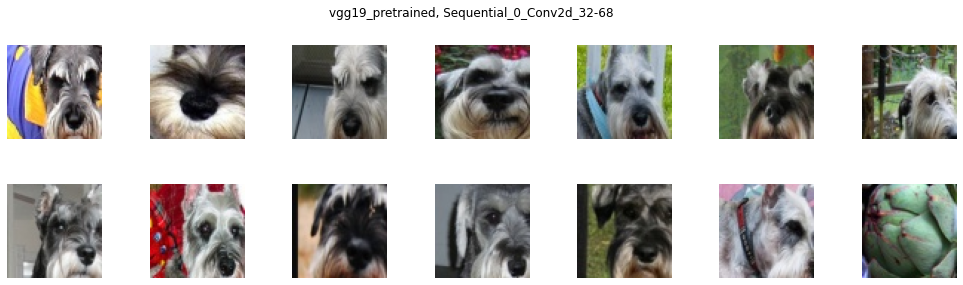

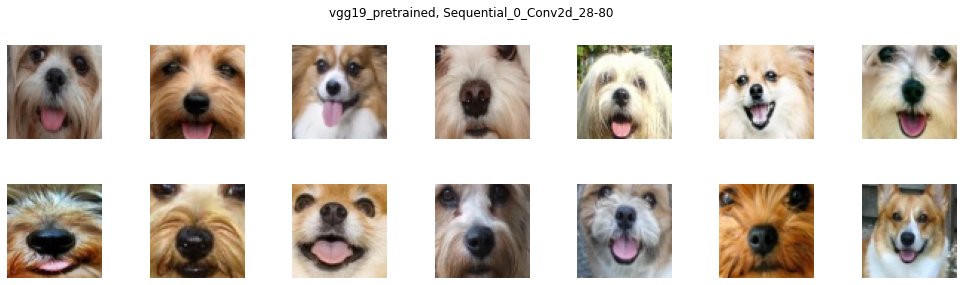

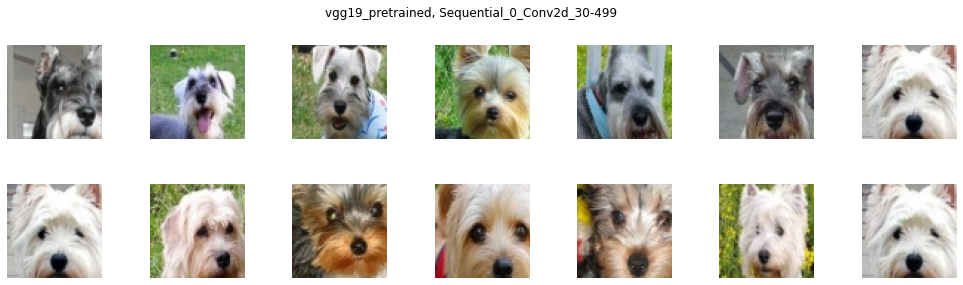

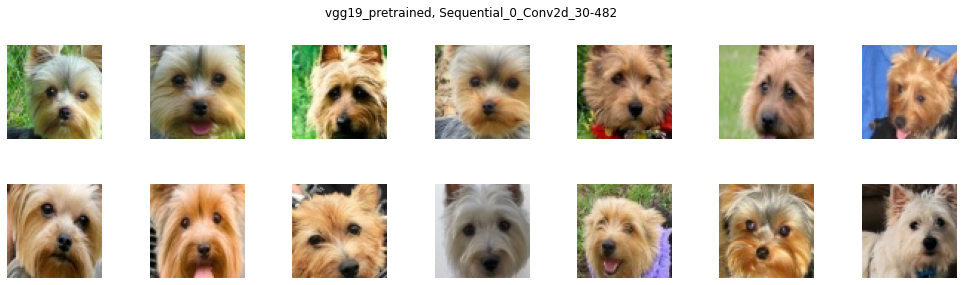

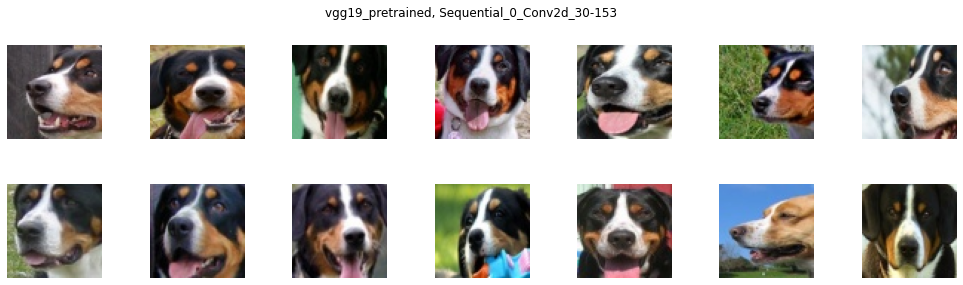

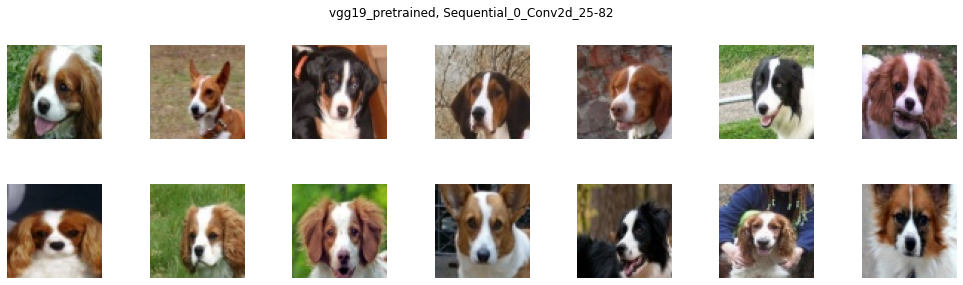

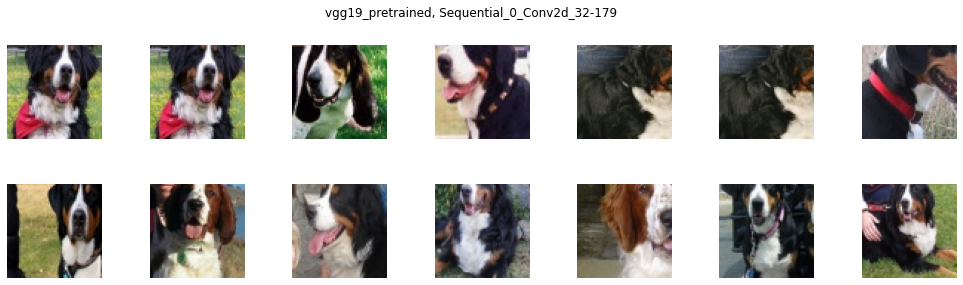

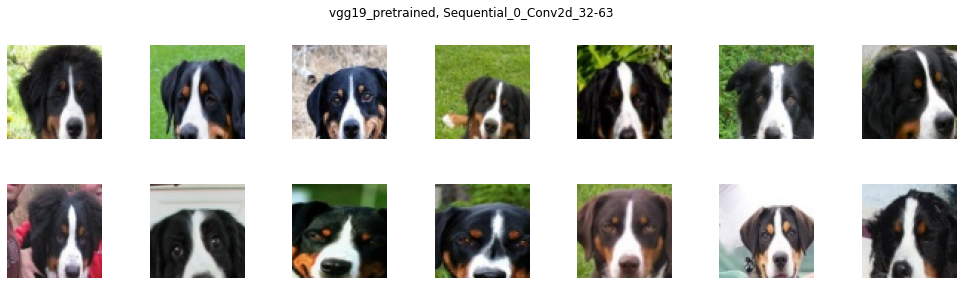

In [5]:
for dog_neuron in vgg19_dog_neurons:
    layer, neuron_idx = dog_neuron.split('-')
    neuron_idx = int(neuron_idx)
    show_ex_patch('vgg19_pretrained', 15, 0.3, layer, neuron_idx)

# 3. Load neuron embedding of the base model

In [34]:
def load_json(p):
    with open(p) as f:
        data = json.load(f)
    return data

def draw_scatter(Xs, title=None, Xs_highlight=None):
    X = Xs[:, 0]
    Y = Xs[:, 1]

    plt.figure(figsize=(4, 4))
    plt.scatter(X, Y, s=5, alpha=0.2, color='gray')
    if title is not None:
        plt.title(title)
    if Xs_highlight is not None:
        X = Xs_highlight[:, 0]
        Y = Xs_highlight[:, 1]
        plt.scatter(X, Y, s=20, alpha=0.2, color='blue')
    plt.show() 

In [7]:
p = '/raid/NeuEvo/data/embedding/emb-vgg19_pretrained-topk_s=20-dim=30-lr_emb=0.05-num_emb_epochs=10000-num_emb_negs=3/data/emb/emb.json'
n_emb = load_json(p)
num_neurons = len(n_emb)

In [8]:
neuron_id2idx = {}
neuron_idx2id = {}
n_X = np.zeros((num_neurons, 30))
for neuron_i, neuron in enumerate(n_emb):
    n_X[neuron_i] = n_emb[neuron]
    neuron_id2idx[neuron] = neuron_i
    neuron_idx2id[neuron_i] = neuron

In [9]:
reducer = umap.UMAP(n_components=2)
reducer = reducer.fit(n_X)
n_X_2d = reducer.embedding_

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [10]:
vgg19_dog_neuron_idxs = np.array([neuron_id2idx[neuron] for neuron in vgg19_dog_neurons])
vgg19_dog_neuron_Xs = n_X_2d[vgg19_dog_neuron_idxs]

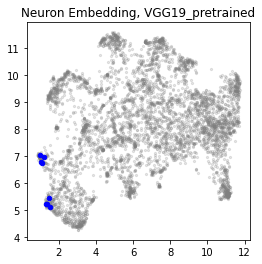

In [11]:
draw_scatter(
    n_X_2d, 
    title="Neuron Embedding, VGG19_pretrained", 
    Xs_highlight=vgg19_dog_neuron_Xs
)

# 4. Load image embedding

In [12]:
p = '/raid/NeuEvo/data/embedding/_etc/_old/vgg19_pretrained/data/img_emb-dim=30-lr_img_emb=10.0-thr_img_emb=0.001-max_iter_img_emb=10000-k=10.txt'
i_X = np.loadtxt(p)

In [13]:
num_imgs = len(i_X)

# 5. Base model's projection

In [14]:
def gen_avg_img_vec(imgs, i_X, dim):
    avg_v = np.zeros(dim)
    for img in imgs:
        avg_v += i_X[img]
    avg_v /= len(imgs)
    return avg_v

In [15]:
p = '/raid/NeuEvo/data/stimulus/vgg19_pretrained/data/stimulus-topk_s=20.json'
base_stimulus = load_json(p)

In [16]:
base_vocab = {}
for layer in base_stimulus:
    for imgs in base_stimulus[layer]:
        for img in imgs:
            if img not in base_vocab:
                base_vocab[img] = 0
            base_vocab[img] += 1

print("Number of total images:", num_imgs)
print(f"Number of images covered by the base model: {len(base_vocab)} ({len(base_vocab) / num_imgs * 100 :.2f}%)")

Number of total images: 1281167
Number of images covered by the base model: 56475 (4.41%)


In [17]:
dim = 30
p_X = np.zeros((num_neurons, dim))
for neuron_i in range(num_neurons):
    neuron_id = neuron_idx2id[neuron_i]
    layer, neuron_idx = neuron_id.split('-')
    neuron_idx = int(neuron_idx)
    imgs = base_stimulus[layer][neuron_idx]
    p_X[neuron_i] = gen_avg_img_vec(imgs, i_X, dim)

In [18]:
p_X_2d = reducer.transform(p_X)

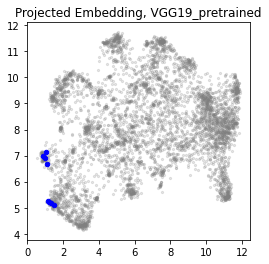

In [19]:
vgg19_dog_neuron_Xs_projected = p_X_2d[vgg19_dog_neuron_idxs]
draw_scatter(
    p_X_2d, 
    title="Projected Embedding, VGG19_pretrained", 
    Xs_highlight=vgg19_dog_neuron_Xs_projected
)

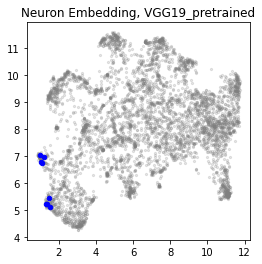

In [20]:
draw_scatter(
    n_X_2d, 
    title="Neuron Embedding, VGG19_pretrained", 
    Xs_highlight=vgg19_dog_neuron_Xs
)

# 6. Dog images covered by the base model

In [22]:
raw_data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

raw_training_datasets = datasets.ImageFolder(
    '../../../../ILSVRC2012/train',
    raw_data_transform
)

def show_imgs(img_idxs):
    for img_idx in img_idxs:
        img = raw_training_datasets[img_idx][0]
        img = np.einsum('kij->ijk', img)
        plt.title(f'img: {img_idx}')
        plt.imshow(img)
        plt.show()
        
def show_img_pair(imgs, title=None):
    nrows = 1
    ncols = 2
    fig, ax = plt.subplots(nrows, ncols, figsize=(2 * ncols, 2 * nrows))
    fig.tight_layout()
    
    for i, img in enumerate(imgs[:nrows * ncols]):
        row = 0
        col = i
        img_np = raw_training_datasets[img][0]
        img_np = np.einsum('kij->ijk', img_np)
        ax[col].imshow(img_np) 
        ax[col].set_axis_off()
    if title is not None:
        fig.suptitle(title)
        
def show_imgs_2_rows(img_idxs, title=None):
    # Images
    imgs = []
    subplot_titles = []
    for i, img_idx in enumerate(img_idxs):
        img = raw_training_datasets[img_idx][0]
        img = np.einsum('kij->ijk', img)
        imgs.append(img)
        subplot_titles.append(f'{i}-th img: {img_idx}')
        
    # Show images
    show_np_imgs_2_rows(imgs, title=title, subplot_titles=subplot_titles)

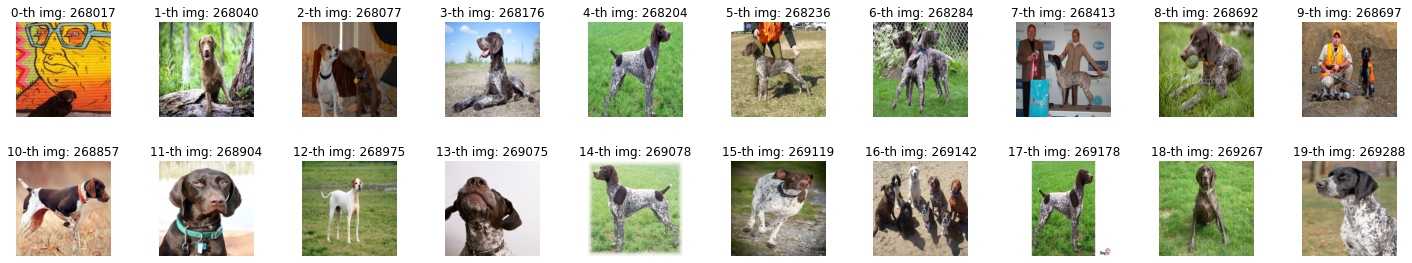

In [23]:
# Dog images in the vocab
dog_imgs = []
i = 0
for img_i in range(268000, 285000):
    if img_i in base_vocab:
        dog_imgs.append(img_i)
        i += 1
        if i >= 2000:
            break
show_imgs_2_rows(dog_imgs[:20])

In [24]:
frequent_dog_imgs = []
for dog_img in dog_imgs:
    if base_vocab[dog_img] > 1:
        print(f'img {dog_img}: {base_vocab[dog_img]}')
        frequent_dog_imgs.append(dog_img)

img 268204: 5
img 268975: 2
img 269078: 2
img 269528: 2
img 269590: 4
img 269611: 2
img 269651: 2
img 269918: 2
img 269939: 3
img 269988: 3
img 270137: 2
img 270165: 3
img 270304: 6
img 270602: 3
img 270692: 7
img 270789: 2
img 270823: 3
img 271084: 2
img 271382: 2
img 271647: 2
img 271720: 2
img 272057: 2
img 272107: 3
img 272116: 4
img 272129: 5
img 272140: 2
img 272202: 2
img 272218: 2
img 272302: 3
img 272336: 9
img 272349: 2
img 272401: 3
img 272479: 2
img 272498: 3
img 272513: 7
img 272519: 2
img 272537: 2
img 272577: 2
img 272665: 3
img 272691: 2
img 272746: 2
img 272751: 3
img 272797: 2
img 272825: 8
img 273204: 3
img 273212: 5
img 273308: 2
img 273480: 2
img 273497: 2
img 273583: 2
img 273617: 2
img 273621: 2
img 273641: 4
img 273800: 5
img 273808: 2
img 273811: 3
img 273871: 2
img 274089: 5
img 274173: 2
img 274242: 2
img 274331: 2
img 274723: 2
img 274751: 3
img 274807: 4
img 274809: 3
img 274920: 6
img 274959: 5
img 274980: 5
img 275001: 2
img 275013: 10
img 275023: 2
img 2

# 7. Image embeddings covered by the base model

In [25]:
num_covered_imgs = len(base_vocab)
raw2covered = {}
covered2raw = {}
i_X_base = np.zeros((num_covered_imgs, dim))
for i, raw_img_idx in enumerate(base_vocab):
    i_X_base[i] = i_X[raw_img_idx]
    raw2covered[raw_img_idx] = i
    covered2raw[i] = raw_img_idx

In [26]:
i_base_X_2d = reducer.transform(i_X_base)

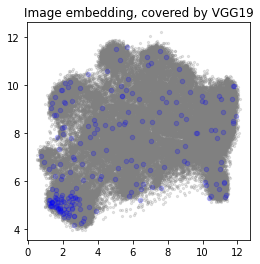

In [35]:
dog_imgs_covered_idxs = [raw2covered[i] for i in frequent_dog_imgs]
dog_i_X_2d = i_base_X_2d[dog_imgs_covered_idxs]

draw_scatter(
    i_base_X_2d, 
    title="Image embedding, covered by VGG19", 
    Xs_highlight=dog_i_X_2d
)

# 8. Show images in a specific spot in the image embedding

In [69]:
# Dogs? Hopefully..
target_imgs = []
for i, v in enumerate(i_base_X_2d):
    x, y = v[0], v[1]
    if 1.3 <= x <= 2.5 and 4.8 <= y <= 5.5:
        target_imgs.append(i)
len(target_imgs)

target_imgs = target_imgs[1000:1050]

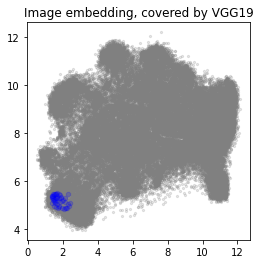

In [70]:
target_i_X_2d = i_base_X_2d[target_imgs]
draw_scatter(
    i_base_X_2d, 
    title="Image embedding, covered by VGG19", 
    Xs_highlight=target_i_X_2d
)

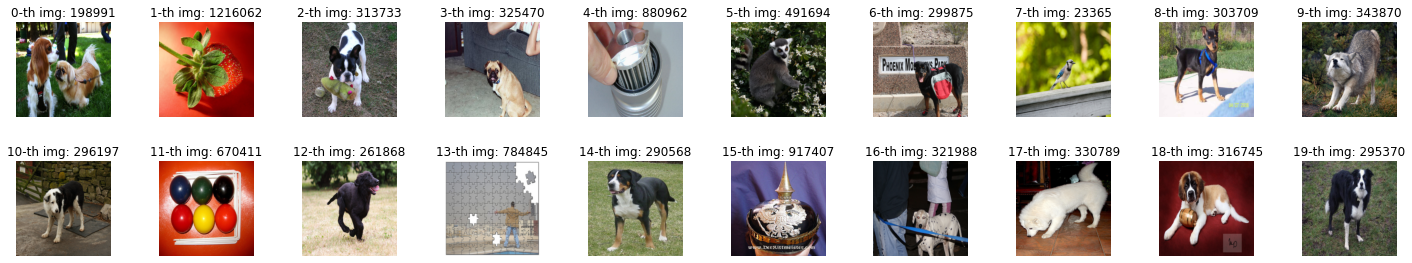

In [71]:
new_target_imgs = [covered2raw[i] for i in target_imgs]
show_imgs_2_rows(new_target_imgs[:20])